In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from pybaselines import Baseline, utils

In [2]:
np.random.seed(12345)

In [45]:
def make_data(num_x, bkg_type='exponential'):
    """Creates the data for the example."""
    x = np.linspace(0, 1000, num_x)
    signal = (
        utils.gaussian(x, 9, 100, 12)
        + utils.gaussian(x, 6, 180, 5)
        + utils.gaussian(x, 8, 350, 11)
        + utils.gaussian(x, 15, 420, 18)
        + utils.gaussian(x, 6, 550, 6)
        + utils.gaussian(x, 13, 700, 8)
        + utils.gaussian(x, 9, 800, 9)
        + utils.gaussian(x, 9, 880, 7)
    )
    if bkg_type == 'exponential':
        baseline = 5 + 15 * np.exp(-x / 400)
    elif bkg_type == 'gaussian':
        baseline = 30 + utils.gaussian(x, 20, 500, 150)
    elif bkg_type == 'linear':
        baseline = 1 + x * 0.005
    elif bkg_type == 'sine':
        baseline = 70 + 5 * np.sin(x / 50)
    else:
        raise ValueError(f'unknown bkg_type {bkg_type}')

    noise = np.random.default_rng(0).normal(0, 0.1, num_x)
    y = signal + baseline + noise

    return x, y, baseline

In [59]:
x, y, true_baseline = make_data(5001)

In [60]:
baseline_fitter = Baseline(x, check_finite=False)

bkg_1 = baseline_fitter.modpoly(y, poly_order=3)[0]
bkg_2 = baseline_fitter.asls(y, lam=1e7, p=0.02)[0]
bkg_3 = baseline_fitter.mor(y, half_window=30)[0]
bkg_4 = baseline_fitter.snip(
    y, max_half_window=40, decreasing=True, smooth_half_window=3
)[0]


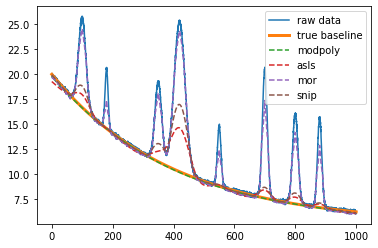

In [61]:
plt.plot(x, y, label='raw data', lw=1.5)
plt.plot(x, true_baseline, lw=3, label='true baseline')
plt.plot(x, bkg_1, '--', label='modpoly')
plt.plot(x, bkg_2, '--', label='asls')
plt.plot(x, bkg_3, '--', label='mor')
plt.plot(x, bkg_4, '--', label='snip')

plt.legend()
plt.show()

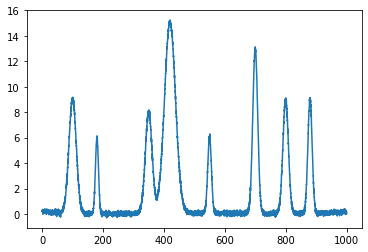

In [62]:
plt.plot(x, y - bkg_1, label='raw data', lw=1.5)
#plt.plot(x, true_baseline, lw=3, label='true baseline')
#plt.plot(x, bkg_1, '--', label='modpoly')


In [63]:
yb = y - bkg_1

In [64]:
data = pd.DataFrame({"x": x, "y": y, "yb": yb})

In [65]:
data.to_csv("peaks_01.csv", sep=";")

In [71]:
peaks = signal.find_peaks(yb, prominence=1, width=1)
peaks

(array([ 500,  901, 1756, 2104, 2753, 3501, 4004, 4399], dtype=int64),
 {'prominences': array([ 9.41807001,  6.36093137,  7.08711403, 15.47699164,  6.44858871,
         13.35880917,  9.30540436,  9.33144865]),
  'left_bases': array([ 303,  772, 1059, 1059, 2630, 3033, 3832, 3832], dtype=int64),
  'right_bases': array([1059, 1059, 1886, 3832, 3033, 3832, 4236, 4524], dtype=int64),
  'widths': array([143.10884753,  58.86804408, 116.0375319 , 215.31605786,
          71.60299696,  95.5967071 , 107.48095533,  83.90705398]),
  'width_heights': array([4.47376717, 2.96838685, 4.6374205 , 7.49429638, 3.07529721,
         6.46072444, 4.46302916, 4.47797342]),
  'left_ips': array([ 429.08279615,  870.44399093, 1692.13724869, 1993.06628832,
         2713.81039983, 3451.9666447 , 3946.60653548, 4357.74931053]),
  'right_ips': array([ 572.19164368,  929.31203501, 1808.17478059, 2208.38234617,
         2785.41339678, 3547.5633518 , 4054.0874908 , 4441.65636451])})

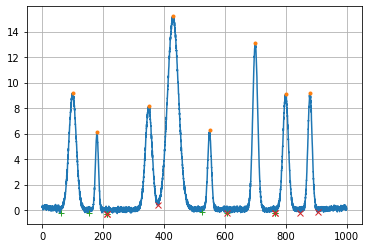

In [28]:
fig, axe = plt.subplots()
axe.plot(x, yb)
axe.plot(x[peaks[0]], yb[peaks[0]], linestyle="none", marker=".")
axe.plot(x[peaks[1]["left_bases"]], yb[peaks[1]["left_bases"]], linestyle="none", marker="+")
axe.plot(x[peaks[1]["right_bases"]], yb[peaks[1]["right_bases"]], linestyle="none", marker="x")
axe.grid()